In [8]:
# deep learning 
import tensorflow as tf #YD: add.compat.v1 to invert to earlier version
# tf.disable_v2_behavior() #YD
import keras.backend as K
from keras.layers import GaussianNoise, Dense, Activation, Input
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.optimize import linear_sum_assignment as linear_assignment
# general tools
import os
import numpy as np
from tqdm import tqdm
from preprocess import *
from io import *


os.chdir("..")
# check current working directory
print("Current Working Directory: ", os.getcwd())

# list files in the current directory
print("Files in Current Directory: ", os.listdir())

Current Working Directory:  /Users/yufeideng/Documents/GitHub/bis687-project
Files in Current Directory:  ['.DS_Store', 'pytest.ini', 'LICENSE', 'requirements.txt', 'sc-env', 'demo.ipynb', 'reproducibility', 'docs', 'README.md', 'results', 'proposal', 'setup.py', 'iterative', '.gitignore', 'scripts', 'dca', '.git', 'LICENSE.txt', 'data', 'tutorial.ipynb', 'scDMFK']


In [19]:
MeanAct = lambda x: tf.clip_by_value(x, 1e-5, 1e6)
DispAct = lambda x: tf.clip_by_value(tf.nn.softplus(x), 1e-4, 1e4)

def cluster_acc(y_true, y_pred):
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1

    return sum([w[i, j] for i, j in zip(row_ind, col_ind)]) * 1.0 / y_pred.size # YD Change

# def multinomial(x, p):
#     print("Runtime shape of x:", x.shape)
#     print("Runtime shape of p:", p.shape) 
#     loss = tf.reduce_mean(-x * tf.math.log(tf.clip_by_value(p, 1e-12, 1.0)))
#     return loss
def multinomial(y_true, y_pred):
    loss = tf.reduce_mean(-y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-12, 1.0)))
    return loss

def _nan2zero(x):
    return tf.where(tf.is_nan(x), tf.zeros_like(x), x)

def _nan2inf(x):
    return tf.where(tf.is_nan(x), tf.zeros_like(x)+np.inf, x)

def _nelem(x):
    nelem = tf.reduce_sum(tf.cast(~tf.is_nan(x), tf.float32))
    return tf.cast(tf.where(tf.equal(nelem, 0.), 1., nelem), x.dtype)

def _reduce_mean(x):
    nelem = _nelem(x)
    x = _nan2zero(x)
    return tf.divide(tf.reduce_sum(x), nelem)

class scDMFK(object):
    def __init__(self, output_dir, input_size, output_size,
                dims=[256,64,32,64,256], alpha=0.001, sigma=1.0, learning_rate=0.0001,
                theta=1, cluster_num=1, noise_sd=1.5, init='glorot_uniform', act='relu', adaptative = True,
                distribution='multinomial', mode='indirect'):
        self.output_dir = output_dir
        self.input_size = input_size
        self.output_size = output_size
        self.dims = dims
        self.cluster_num = cluster_num
        self.alpha = alpha
        self.sigma = sigma
        self.theta = theta
        self.learning_rate = learning_rate
        self.noise_sd = noise_sd
        self.init = init
        self.act = act
        self.adaptative = adaptative
        self.distribution = distribution
        self.mode = mode
        self.model = None
        self.loss = None
        self.optimizer = None
        
        # input layer
        self.x_count = Input(shape=(self.input_size,), name='count')
        self.sf_layer = Input(shape=(1,), name='size_factors')

        # latent layers
        self.h = self.x_count
        self.h = GaussianNoise(self.noise_sd, name='input_noise')(self.h)
        for i, hid_size in enumerate(self.dims):
            center_idx = int(np.floor(len(self.dims) / 2.0))
            if i == center_idx:
                layer_name = 'hidden'
                self.latent = Dense(units=self.dims[-1], kernel_initializer=self.init,
                                    name=layer_name)(self.h)  # hidden layer, features are extracted from here
                self.h = self.latent
            elif i < center_idx:
                layer_name = 'encoder%s' % i
                self.h = Dense(units=hid_size, kernel_initializer=self.init, name=layer_name)(self.h)
                self.h = GaussianNoise(self.noise_sd, name='noise_%d' % i)(self.h)  # add Gaussian noise
                self.h = Activation(self.act)(self.h)
            else:
                layer_name = 'decoder%s' % (i-center_idx)
                self.h = Dense(units=self.dims[i], activation=self.act, kernel_initializer=self.init, 
                            name=layer_name)(self.h)    
        
        # output layers       
        if self.distribution == "multinomial":
            if mode == "indirect":                    
                self.mean = Dense(units=self.output_size, activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h)
                self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32))
                self.pi = Dense(units=self.output_size, activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h)
                self.P = tf.transpose(tf.transpose(self.pi * self.output) / tf.reduce_sum(self.pi * self.output, axis=1))
                self.pre_loss = multinomial
            else:
                self.P = Dense(units=self.output_size, activation=tf.nn.softmax, kernel_initializer=self.init, name='pi')(self.h)
                self.pre_loss = multinomial
            
            # put together full model architecture
            self.model = Model(inputs=[self.x_count, self.sf_layer], outputs=self.P)  
            
        ###The rest models need modification!!!!!!!
        ##### Need to define their own loss function in the form loss(y_true, y_pred) 
        ##### and "output" tensor in order to correctly compile and fit model
        elif self.distribution == "ZINB":       
            self.pi = Dense(units=self.output_size, activation='sigmoid', kernel_initializer=self.init, name='pi')(self.h)
            self.disp = Dense(units=self.output_size, activation=DispAct, kernel_initializer=self.init, name='dispersion')(self.h)
            self.mean = Dense(units=self.output_size, activation=MeanAct, kernel_initializer=self.init, name='mean')(self.h)
            self.output = self.mean * tf.matmul(self.sf_layer, tf.ones((1, self.mean.get_shape()[1]), dtype=tf.float32))
            self.pre_loss = ZINB(self.pi, self.disp, self.x_count, self.output, ridge_lambda=1.0)
        elif self.distribution == "weight mse":
            self.recon_x = Dense(units=self.output_size, kernel_initializer=self.init, name='reconstruction')(self.h)
            self.weight_mse = weight_mse(self.x_count, self.x, self.recon_x)
        else:
            self.recon_x = Dense(units=self.output_size, kernel_initializer=self.init, name='reconstruction')(self.h)
            self.mask_mse = mask_mse(self.x_count, self.x, self.recon_x)
        
        # get hidden representation: encoder output
        self.encoder = Model(inputs=self.model.input, outputs=self.model.get_layer('hidden').output)


    def predict(self, adata, mode='full', copy=False):      
        adata = adata.copy() if copy else adata

        if mode in ('denoise', 'full'):
            print('Calculating reconstructions...')
            adata.X = self.model.predict({'count': adata.X,
                                        'size_factors': adata.obs.size_factors})
        
        if mode in ('latent', 'full'):
            print('Calculating hidden representation...')
            adata.obsm['X_hidden'] = self.encoder.predict({'count': adata.X,
                                                    'size_factors': adata.obs.size_factors})
        
        return adata if copy else None

    def write(self, adata, mode='full', colnames=None, rownames=None):  #YD added
        colnames = adata.var_names.values if colnames is None else colnames
        rownames = adata.obs_names.values if rownames is None else rownames 
        
        data_path = 'data/' + self.output_dir + '/'
        os.makedirs(data_path, exist_ok=True) 
        
        if mode in ('denoise', 'full'):
            print('scDM: Saving denoised output to %s' % data_path)
            out = adata.X #* adata.raw.X.sum(1)[:, np.newaxis]
            write_text_matrix(out,
                            os.path.join(data_path, 'mean-scdm.csv'),
                            rownames=rownames, colnames=colnames, transpose=False)
        
        if mode in ('latent', 'full'):
            print('scDM: Saving latent representation to %s' % data_path)
            write_text_matrix(adata.obsm['X_hidden'],
                            os.path.join(data_path, 'latent-scdm.csv'),
                            rownames=rownames, colnames=colnames, transpose=False)
    
    
    def pretrain(self, adata, size_factor, batch_size, pretrain_epoch, gpu_option,
                use_raw_as_output=True):
        print("begin the pretraining")
        init = tf.group(tf.compat.v1.global_variables_initializer(), 
                        tf.compat.v1.local_variables_initializer())
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_option
        config_ = tf.compat.v1.ConfigProto()
        config_.gpu_options.allow_growth = True
        config_.allow_soft_placement = True
        tf.compat.v1.keras.backend.set_session(
            tf.compat.v1.Session(
                config=config_
            )
        )
        
        self.optimizer = tf.optimizers.Adam(self.learning_rate)
        self.model.compile(loss=self.pre_loss, optimizer=self.optimizer)
        
        inputs = {'count': adata.X , 'size_factors': size_factor}
        
        # get multinomial probabilities
        # raw_probs = pd.DataFrame(adata.raw.X / adata.raw.X.sum(1)[:,np.newaxis],columns=adata.raw.var_names)
        # high_variable_probs = raw_probs[adata.var_names]
        # output = high_variable_probs.to_numpy()
        output = adata.raw.X
        
        self.model.fit(inputs, output,
                        epochs=pretrain_epoch,
                        batch_size=batch_size,
                        validation_split=0.1)
    
    def print_summary(self):
        self.model.summary()
            

In [21]:
def normalize(adata, highly_genes = None, highly_subset=False, size_factors=True, normalize_input=True, logtrans_input=True):
    sc.pp.filter_genes(adata, min_counts=1)
    sc.pp.filter_cells(adata, min_counts=1)
    if size_factors or normalize_input or logtrans_input:
        adata.raw = adata.copy()
    else:
        adata.raw = adata

    if size_factors:
        sc.pp.normalize_per_cell(adata)
        adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)
    else:
        adata.obs['size_factors'] = 1.0

    if logtrans_input:
        sc.pp.log1p(adata)

    if normalize_input:
        sc.pp.scale(adata)

    highly_genes = adata.n_vars if None else highly_genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=highly_genes, subset=highly_subset)

    return adata

In [22]:
# load data
dataname = "endoderm/endoderm.csv"
output_dir = None
transpose = True
highly_genes = None
highly_subset=False
adata = prepro(dataname)
if transpose:
    adata = adata.transpose()
adata = normalize(adata, highly_genes=highly_genes, highly_subset=highly_subset)
high_variable = adata.var.highly_variable

# X = adata.X.astype(np.float32)
# count_X = X
# count_X = count_X[:, high_variable]
input_size = adata.n_vars
output_size = input_size
size_factor = np.array(adata.obs.size_factors).reshape(-1, 1).astype(np.float32)

Successfully preprocessed 1018 genes and 19097 cells


In [25]:
model = scDMFK(output_dir, input_size, output_size, dims=[64,32,64], learning_rate=0.001)
model.pretrain(adata, size_factor, batch_size=32, pretrain_epoch=100, gpu_option='0')

begin the pretraining



2024-04-18 16:32:46.763168: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
32/32 [==============================] - 2s 38ms/step - loss: 2677.7078
Epoch 2/100
32/32 [==============================] - 1s 38ms/step - loss: 2249.9167
Epoch 3/100
32/32 [==============================] - 1s 36ms/step - loss: 2184.4034
Epoch 4/100
32/32 [==============================] - 1s 36ms/step - loss: 2153.6203
Epoch 5/100
32/32 [==============================] - 1s 40ms/step - loss: 2129.4945
Epoch 6/100
32/32 [==============================] - 2s 55ms/step - loss: 2157.1114
Epoch 7/100
32/32 [==============================] - 1s 41ms/step - loss: 2078.5102
Epoch 8/100
32/32 [==============================] - 1s 39ms/step - loss: 2097.1516
Epoch 9/100
32/32 [==============================] - 1s 40ms/step - loss: 2048.1228
Epoch 10/100
32/32 [==============================] - 1s 43ms/step - loss: 2082.5959
Epoch 11/100
32/32 [==============================] - 1s 38ms/step - loss: 2088.2584
Epoch 12/100
32/32 [==============================] - 1s 37ms/step - loss:

In [41]:
# model.predict(adata, mode='denoise')
endoderm_scdm = pd.DataFrame(adata.X, 
                             index=adata.obs_names, columns=adata.var_names) * adata.raw.X.sum(1)[:,np.newaxis]
endoderm_scdm
# # DCA prediction
# endoderm_dca = pd.read_csv('/home/dengyf2000/bis687-project/data/endoderm/mean.tsv', sep='\t', index_col=0)
# endoderm_dca.T[adata.var_names]

,MKL2,CD109,ABTB1,MAST2,KAT5,WWC2,CD163,UBE2Z,RGPD4,PHYHIPL,...,SNRNP48,ARMC3,DUSP28,INO80,NUP205,WDR33,EPSTI1,CLPTM1L,CCDC125,CATSPER3
H1_Exp1.001,269.041595,0.053676,0.059630,0.064818,0.065017,108.288116,0.053274,0.078909,0.061104,0.056234,...,0.078035,0.053537,0.058868,0.064904,895.256226,296.204041,0.058909,0.066320,0.064459,0.057113
H1_Exp1.002,390.495117,0.077906,0.086549,0.094078,0.094367,157.172562,0.077323,0.114530,0.088688,0.081620,...,0.113263,0.077705,0.085443,0.094204,1299.401611,429.919312,0.085502,0.096259,0.093558,0.082895
H1_Exp1.003,310.970947,0.062041,0.068923,0.074919,0.075149,125.164497,0.061577,0.091206,0.070627,0.064998,...,0.090197,0.061880,0.068042,0.075019,1034.779053,342.366455,0.068089,0.076656,0.074505,0.066014
H1_Exp1.004,250.493393,0.049975,0.055519,0.060349,0.060534,100.822624,0.049601,0.073469,0.056891,0.052357,...,0.072655,0.049846,0.054810,0.060429,833.535583,275.783203,0.054847,0.061748,0.060015,0.053175
H1_Exp1.006,255.631958,0.051000,0.056658,0.061587,0.061776,102.890800,0.050619,0.074976,0.058058,0.053431,...,0.074146,0.050868,0.055934,0.061669,850.634644,281.440521,0.055973,0.063015,0.061246,0.054266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TB_Batch2.140,715.695801,0.142787,0.158627,0.172427,0.172956,288.065613,0.141719,0.209911,0.162547,0.149593,...,0.207588,0.142417,0.156600,0.172656,2381.541016,787.956787,0.156708,0.176424,0.171474,0.151930
TB_Batch2.141,716.423035,0.142932,0.158788,0.172602,0.173132,288.358582,0.141863,0.210125,0.162712,0.149745,...,0.207799,0.142562,0.156759,0.172832,2383.959961,788.757751,0.156867,0.176603,0.171648,0.152085
TB_Batch2.142,1080.594971,0.215587,0.239504,0.260339,0.261138,434.937012,0.213974,0.316936,0.245422,0.225864,...,0.313428,0.215029,0.236443,0.260686,3595.777100,1189.701416,0.236606,0.266374,0.258900,0.229393
TB_Batch2.143,1005.164795,0.200538,0.222785,0.242166,0.242910,404.575897,0.199038,0.294812,0.228291,0.210098,...,0.291549,0.200019,0.219938,0.242489,3344.773193,1106.652344,0.220090,0.247780,0.240827,0.213380


In [29]:
endoderm = pd.DataFrame(adata.raw.X, index=adata.obs_names, columns=adata.raw.var_names)[adata.var_names]
endoderm

,MKL2,CD109,ABTB1,MAST2,KAT5,WWC2,CD163,UBE2Z,RGPD4,PHYHIPL,...,SNRNP48,ARMC3,DUSP28,INO80,NUP205,WDR33,EPSTI1,CLPTM1L,CCDC125,CATSPER3
H1_Exp1.001,10.0,6.0,0.0,0.0,0.0,84.0,0.0,18.0,0.0,0.0,...,84.0,0.0,0.0,0.0,239.0,101.0,0.0,22.0,32.0,0.0
H1_Exp1.002,162.0,2.0,28.0,133.0,7.0,5.0,0.0,146.0,4.0,0.0,...,40.0,0.0,0.0,187.0,231.0,201.0,0.0,84.0,52.0,0.0
H1_Exp1.003,3.0,166.0,0.0,41.0,52.0,305.0,0.0,106.0,0.0,0.0,...,21.0,0.0,0.0,6.0,169.0,23.0,0.0,19.0,110.0,0.0
H1_Exp1.004,42.0,9.0,1.0,0.0,20.0,41.0,0.0,9.0,0.0,0.0,...,12.0,0.0,0.0,49.0,90.0,164.0,0.0,52.0,73.0,1.0
H1_Exp1.006,0.0,7.0,0.0,0.0,0.0,142.0,0.0,14.0,5.0,0.0,...,41.0,0.0,0.0,26.0,240.0,181.0,0.0,2.0,53.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TB_Batch2.140,5.0,23.0,0.0,206.0,0.0,46.0,0.0,74.0,0.0,0.0,...,185.0,0.0,0.0,7.0,0.0,5.0,146.0,0.0,221.0,0.0
TB_Batch2.141,500.0,362.0,0.0,43.0,56.0,90.0,0.0,15.0,0.0,0.0,...,156.0,0.0,0.0,0.0,251.0,79.0,539.0,296.0,166.0,0.0
TB_Batch2.142,18.0,22.0,3.0,2.0,2.0,562.0,0.0,25.0,0.0,0.0,...,10.0,0.0,0.0,28.0,0.0,6.0,0.0,0.0,131.0,0.0
TB_Batch2.143,472.0,36.0,39.0,1.0,0.0,778.0,0.0,225.0,2.0,0.0,...,719.0,0.0,0.0,211.0,2.0,124.0,21.0,271.0,730.0,0.0


In [35]:
# from scDMFK.io import get_embedding, draw_umap
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score


In [38]:
def calculate_cluster_results(data, true_labels, seed):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    
    n_clusters = len(np.unique(true_labels))
    np.random.seed(seed)
    
    # get UMAP 2-D embedding
    embedding = get_embedding(data)
    draw_umap(embedding, true_labels)
    
    # K-means for clustering umi embedings
    kmeans = KMeans(n_clusters=n_clusters).fit(embedding)
    labels = kmeans.labels_

    # Calculate metrics
    ari = adjusted_rand_score(true_labels, labels)
    nmi = normalized_mutual_info_score(true_labels, labels)
    sc = silhouette_score(data, labels)

    print(f'Adjusted Rand Index: {ari}')
    print(f'Normalized Mutual Information: {nmi}')
    print(f'Silhouette Coefficient: {sc}')
    
    return ari, nmi, sc


In [44]:
endoderm_scdm.loc[:,adata.var.highly_variable]

,ABTB1,APOA2,HIST1H2BC,RSPH9,MT-ND4,HIST1H4F,TNNT2,GSDMD,FBXL17,DDI2,...,ADAMTS7,TCEANC,ITGA9,LRRC2,PDE11A,CCDC144NL,SYDE1,NTNG1,DDA1,EPSTI1
H1_Exp1.001,0.059630,0.054591,0.060004,0.060523,906.556213,0.057062,0.060804,0.062685,0.061477,0.060828,...,0.060652,0.061470,0.053243,0.079618,0.068814,0.061093,0.060934,0.057632,0.065221,0.058909
H1_Exp1.002,0.086549,0.079235,0.087092,0.087845,1315.802368,0.082822,0.088252,0.090983,0.089229,0.088288,...,0.088032,0.089219,0.077278,0.115560,0.099878,0.088672,0.088442,0.083649,0.094663,0.085502
H1_Exp1.003,0.068923,0.063099,0.069356,0.069955,1047.839966,0.065955,0.070280,0.072454,0.071058,0.070308,...,0.070104,0.071050,0.061540,0.092026,0.079538,0.070614,0.070430,0.066614,0.075385,0.068089
H1_Exp1.004,0.055519,0.050827,0.055867,0.056350,844.056519,0.053128,0.056612,0.058364,0.057239,0.056635,...,0.056471,0.057232,0.049572,0.074129,0.064070,0.056881,0.056733,0.053659,0.060724,0.054847
H1_Exp1.006,0.056658,0.051870,0.057013,0.057506,861.371216,0.054218,0.057773,0.059561,0.058413,0.057796,...,0.057629,0.058406,0.050589,0.075650,0.065384,0.058048,0.057897,0.054760,0.061970,0.055973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TB_Batch2.140,0.158627,0.145222,0.159622,0.161002,2411.604004,0.151796,0.161749,0.166754,0.163540,0.161814,...,0.161345,0.163521,0.141635,0.211799,0.183057,0.162518,0.162096,0.153312,0.173499,0.156708
TB_Batch2.141,0.158788,0.145370,0.159784,0.161166,2414.054932,0.151950,0.161913,0.166923,0.163706,0.161978,...,0.161509,0.163687,0.141779,0.212014,0.183243,0.162684,0.162261,0.153467,0.173675,0.156867
TB_Batch2.142,0.239504,0.219264,0.241006,0.243090,3641.171631,0.229189,0.244217,0.251774,0.246921,0.244315,...,0.243608,0.246892,0.213849,0.319785,0.276389,0.245379,0.244741,0.231478,0.261958,0.236606
TB_Batch2.143,0.222785,0.203959,0.224182,0.226121,3386.996582,0.213191,0.227169,0.234199,0.229685,0.227261,...,0.226603,0.229658,0.198921,0.297462,0.257096,0.228250,0.227657,0.215320,0.243672,0.220090


/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


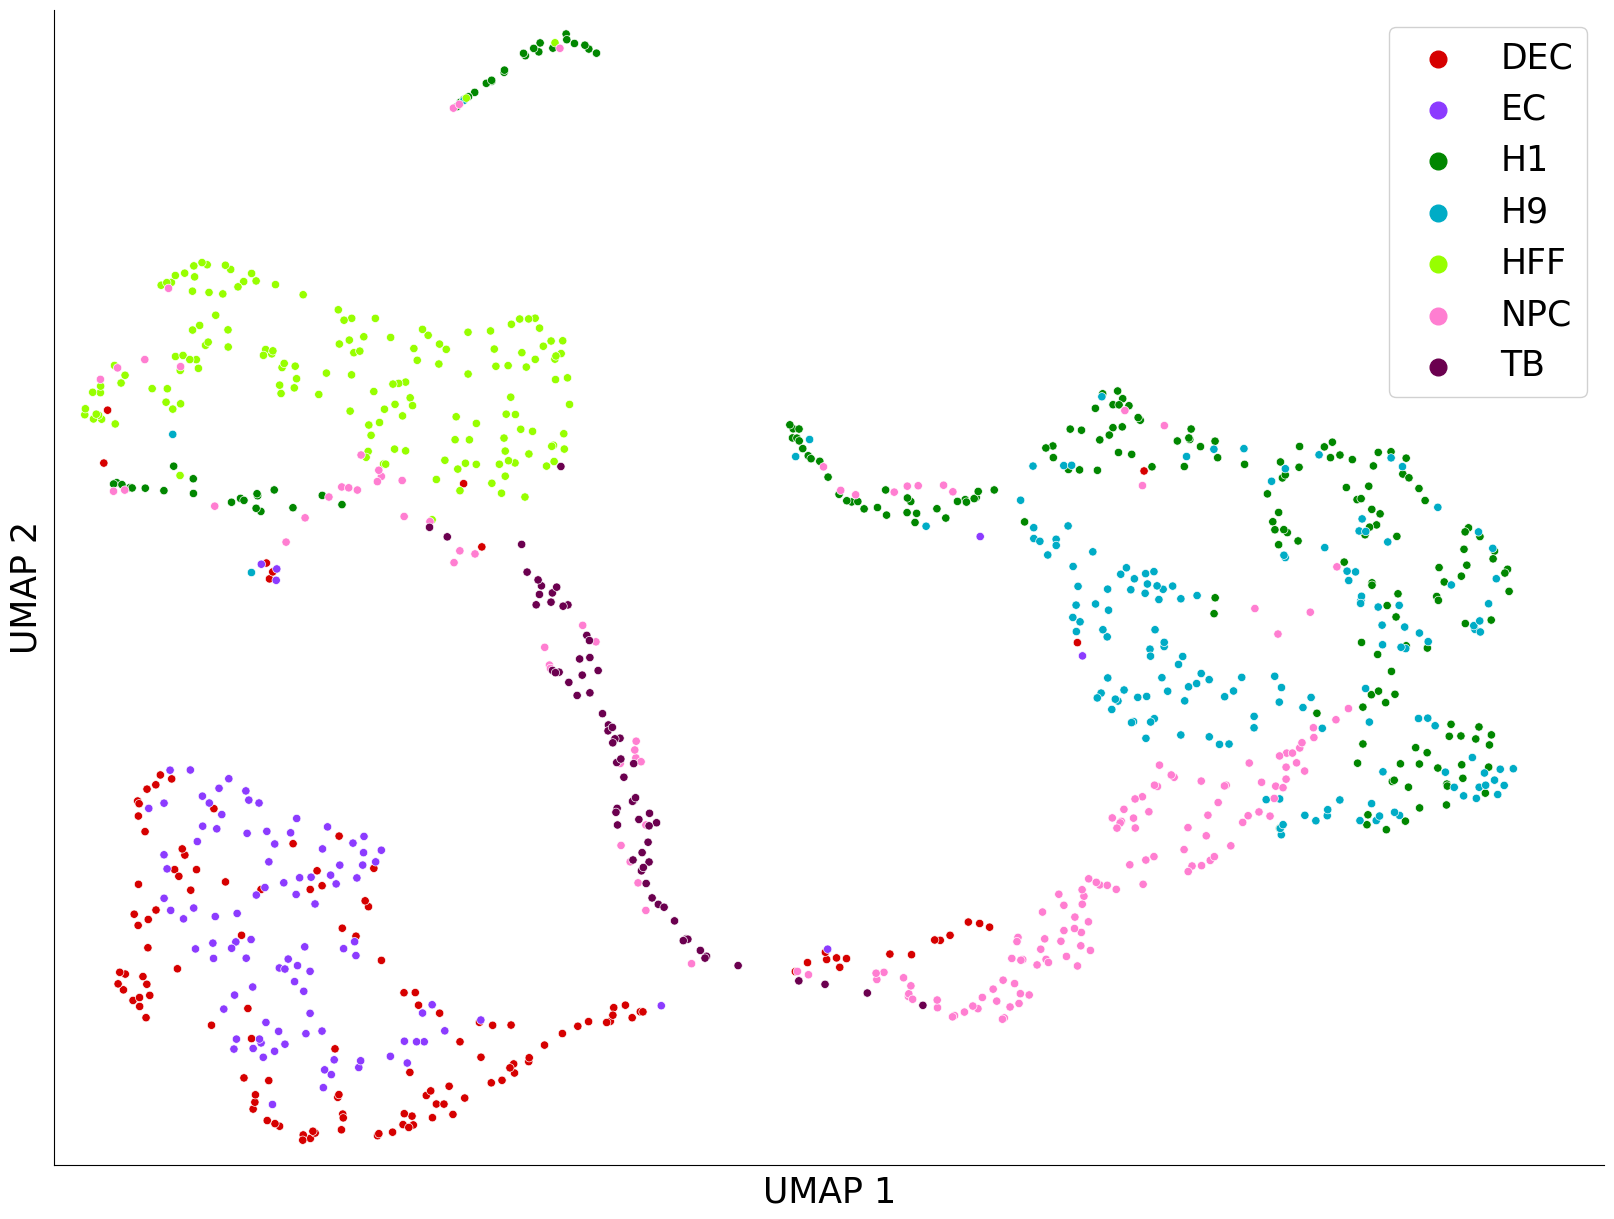

/Users/yufeideng/Documents/GitHub/bis687-project/sc-env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Adjusted Rand Index: 0.41118238322764256
Normalized Mutual Information: 0.5464957388358257
Silhouette Coefficient: -0.22796015441417694


(0.41118238322764256, 0.5464957388358257, -0.22796015)

In [46]:
random_seed = [1111,22222,3333,4444,5555,6666,7777,8888,9999]
end_label = [label.split("_")[0] for label in endoderm_scdm.index.to_list()]
calculate_cluster_results(endoderm_scdm.loc[:,adata.var.highly_variable],
                        end_label, 1111)